In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from sklearn.datasets import make_blobs

In [2]:
def my_confusion_matrix(y_test, y_hat, names):
    '''This function uses the pd.crosstab function to create a confusion matrix:
    predictions are the predictions from the predictive mode
    y are the known class labels
    names are the names of the features used in the model'''
    
    cf = pd.crosstab(y_test, y_hat)
    cf.columns = names
    cf.index = names
    cf.columns.name = 'Prediction'
    cf.index.name = 'Actual'
    return cf

---
A Neural Network Implementation
=====
***

In [3]:
class my_NeuralNet(object):
    """Implements a basic neural network
    """
    
    def __init__(self, hidden = 10, eta = 0.01, iterations = 100, epsilon = 5.0, lam = 0.0):
        
        #sets the number of hidden units
        self.nn_hidden = hidden
        
        #sets the learning rate
        self.eta = eta
        
        #sets the weight decay parameter
        self.lam = lam
        
        #sets the number of iterations
        self.iterations = iterations
        
        #the weights initialization parameters
        self.epsilon = epsilon
        
        #initialiszes the number of classes, the number of features, etc
        self.nn_classes = 0
        self.nn_features = 0
        self.targets = 0
        self.weights_1 = 0
        self.weights_2 = 0
        self.nn_train = 0
        self.training_mse = []
        self.testing_mse = []
        self.min_mse = 0.0
        self.final_n = 0
        
    def activation(self, a):
        '''This is just the sigmoid or logistic function'''
        return 1.0/(1.0 + np.exp(-a))

    def calc_Ak(self, A, k, nn_out):
        '''This is the implementation of softmax'''
    
        sum_k = 0.0
        for kprime in xrange(nn_out):
            if k != kprime:
                sum_k += np.exp(A[kprime])
            
        return A[k] - np.log(sum_k)

    def calc_se(self, y, t):
        '''Calculates one half times the squared error'''
    
        temp = (y - t) * (y - t)
        return 0.5 * temp.sum()
        
    def retrieve_final_n(self):
        return self.final_n
        
    def retrieve_min_mse(self):
        return self.final_n
        
    def retrieve_weights(self):
        return (self.weights_1, self.weights_2)
    
    def retrieve_training_mse(self):
        return self.training_mse
        
    def retrieve_testing_mse(self):
        return self.testing_mse
        
    def convert_to_yhat(self, t):
        y_hat = np.zeros((len(t)))
        for i in xrange(len(t)):
            y_hat[i] = t[i].argmax()
        return y_hat
    
    def convert_to_binary(self, y):        
        targets = np.zeros((len(y), self.nn_classes))
        for i, j in enumerate(y):
            targets[i][j] = 1.0
        return targets

    def fit(self, X, y):
        '''Fits a neural network to the training set X'''
        
        #set the number of classes to be the number of unique class identifiers in y
        self.nn_classes = len(np.unique(y))
        self.targets = self.convert_to_binary(y)
        
        self.nn_train = X.shape[0]
        self.nn_features = X.shape[1]
        
        nn_input = np.zeros((1, self.nn_features + 1))
        nn_input_2 = np.zeros((1, (self.nn_hidden + 1)))
    
        #self.weights_1 = np.zeros((self.nn_features+1, self.nn_hidden))
        self.weights_1 = ((np.random.rand((self.nn_features + 1) * self.nn_hidden) * 2.0 * self.epsilon) - self.epsilon).reshape((self.nn_features + 1), self.nn_hidden)

        #self.weights_2 = np.zeros((self.nn_hidden+1, self.nn_classes))
        self.weights_2 = ((np.random.rand((self.nn_hidden + 1) * self.nn_classes) * 2.0 * self.epsilon) - self.epsilon).reshape((self.nn_hidden + 1), self.nn_classes)

        pre_out = np.zeros((1, self.nn_classes))
    
        training_mse = []

        for n in xrange(self.iterations):
            mse = 0.0
            if (n>0) & (n%100 == 0):
                print '.',
            for r in xrange(self.nn_train):
        
                #get the input vector from the training set
                nn_input[0, 1:] = X[r,:]
        
                #set the bias to 1.0
                nn_input[0][0] = 1.0

                #mulitply the input vector with the matrix of weights
                A_1 = np.dot(nn_input, self.weights_1)
        
                #calculate the activation function
                A_1 = self.activation(A_1)
        
                #calculate the derivative - anticipating backprogagation
                Z1 = A_1 * (1.0 - A_1)
    
                #A_1 is the input into the next layer
                nn_input_2[0, 1:] = A_1
        
                #set the bias for the next layer
                nn_input_2[0][0] = 1.0
        
                #multiply the input vector with the matrix of weights
                A_2 = np.dot(nn_input_2, self.weights_2)

                #compute the 'soft max' so that each output will be a probability and that all outputs sum to 1
                for k in xrange(self.nn_classes):
                    pre_out[0][k] =  self.calc_Ak(A_2[0], k, self.nn_classes)
                n_outputs = self.activation(pre_out)

                #calculate the ouput layer delta
                delta2 = n_outputs - self.targets[r]
    
                mse += self.calc_se(n_outputs[0], self.targets[r])
                
                #backpropagate the error
                BP2 = np.dot(delta2, self.weights_2.T)
                
                #Biases do not need to be updated
                BP2 = BP2[:,1:].copy()
                
                #Calculate the delta at the hidden layer
                delta1 = BP2 * Z1
        
                for i in xrange(self.nn_features + 1):
                    for j in xrange(self.nn_hidden):
                        self.weights_1[i][j] += -(self.eta * delta1[0][j] * nn_input[0][i]) - (self.eta * self.lam * self.weights_1[i][j])
            
                for i in xrange(self.nn_hidden + 1):
                    for j in xrange(self.nn_classes):
                        self.weights_2[i][j] += -(self.eta * delta2[0][j] * nn_input_2[0][i]) - (self.eta * self.lam * self.weights_2[i][j])
     
            mse = mse/self.nn_train
            training_mse.append(mse)
        self.training_mse = training_mse
    
    def predict(self, X):
        nn_classes = self.weights_2.shape[1]
        #print nn_classes
    
        nn_hidden = self.weights_1.shape[1]
        #print nn_hidden
    
        nn_features = X.shape[1]
        #print nn_features
        
        nn_input = np.zeros((1, self.nn_features + 1))
        nn_input_2 = np.zeros((1, (nn_hidden + 1)))
        pre_out = np.zeros((1, nn_classes))
    
        all_outputs = np.zeros((X.shape[0], nn_classes))
    
        for r in xrange(X.shape[0]):
            nn_input[0, 1:] = X[r,:]
            nn_input[0][0] = 1.0

            A_1 = np.dot(nn_input, self.weights_1)
        
            nn_input_2[0, 1:] = self.activation(A_1)
            nn_input_2[0][0] = 1.0
        
            A_2 = np.dot(nn_input_2, self.weights_2)

            for k in xrange(nn_classes):
                pre_out[0][k] =  self.calc_Ak(A_2[0], k, nn_classes)
            n_outputs = self.activation(pre_out)
            all_outputs[r, :] = n_outputs
        
        return self.convert_to_yhat(all_outputs)
    
    def fit_es(self, X, y, Xv, yv):
        '''This function is fit early stopping. It is similar to fit but at each iteration of training it evaluates the mse on the provided validation set'''
        
        #set the number of classes to be the number of unique class identifiers in y
        self.nn_classes = len(np.unique(y))
        self.targets = self.convert_to_binary(y)
        test_targets = self.convert_to_binary(yv)
        
        self.nn_train = X.shape[0]
        self.nn_features = X.shape[1]
        
        nn_input = np.zeros((1, self.nn_features + 1))
        nn_input_2 = np.zeros((1, (self.nn_hidden + 1)))
    
        #self.weights_1 = np.zeros((self.nn_features+1, self.nn_hidden))
        l_weights_1 = ((np.random.rand((self.nn_features + 1) * self.nn_hidden) * 2.0 * self.epsilon) - self.epsilon).reshape((self.nn_features + 1), self.nn_hidden)

        #self.weights_2 = np.zeros((self.nn_hidden+1, self.nn_classes))
        l_weights_2 = ((np.random.rand((self.nn_hidden + 1) * self.nn_classes) * 2.0 * self.epsilon) - self.epsilon).reshape((self.nn_hidden + 1), self.nn_classes)

        pre_out = np.zeros((1, self.nn_classes))
    
        training_mse = []
        testing_mse = []
        min_mse = 9.9e99

        for n in xrange(self.iterations):
            mse = 0.0
            if (n>0) & (n%100 == 0):
                print '.',
            for r in xrange(self.nn_train):
        
                #get the input vector from the training set
                nn_input[0, 1:] = X[r,:]
        
                #set the bias to 1.0
                nn_input[0][0] = 1.0

                #mulitply the input vector with the matrix of weights
                A_1 = np.dot(nn_input, l_weights_1)
        
                #calculate the activation function
                A_1 = self.activation(A_1)
        
                #calculate the derivative - anticipating backprogagation
                Z1 = A_1 * (1.0 - A_1)
    
                #A_1 is the input into the next layer
                nn_input_2[0, 1:] = A_1
        
                #set the bias for the next layer
                nn_input_2[0][0] = 1.0
        
                #multiply the input vector with the matrix of weights
                A_2 = np.dot(nn_input_2, l_weights_2)

                #compute the 'soft max' so that each output will be a probability and that all outputs sum to 1
                for k in xrange(self.nn_classes):
                    pre_out[0][k] =  self.calc_Ak(A_2[0], k, self.nn_classes)
                n_outputs = self.activation(pre_out)
                
                #keep a running total of the squared error for each training example
                mse += self.calc_se(n_outputs[0], self.targets[r])
                
                #The output layer delta is just the output - the target
                delta2 = n_outputs - self.targets[r]

                #backpropagate the delta by multiplying the output delta (delta 2 by the weights matrix transposed)
                BP2 = np.dot(delta2, l_weights_2.T)
                BP2 = BP2[:,1:].copy()
                
                #calculate the delta at the hidden layer
                delta1 = BP2 * Z1
        
                #use the derivative information to update the weights. lam is the regularizer to keep the weights from becoming too large
                #eta is the learning rate
                for i in xrange(self.nn_features + 1):
                    for j in xrange(self.nn_hidden):
                        l_weights_1[i][j] += -(self.eta * delta1[0][j] * nn_input[0][i]) - (self.eta * self.lam * l_weights_1[i][j])
            
                for i in xrange(self.nn_hidden + 1):
                    for j in xrange(self.nn_classes):
                        l_weights_2[i][j] += -(self.eta * delta2[0][j] * nn_input_2[0][i]) - (self.eta * self.lam * l_weights_2[i][j])
     
            #get the training mean squared error
            mse = mse/self.nn_train
            
            #append this to the training list
            training_mse.append(mse)
        
            #use the predict early stopping routine to get the validation mean squared error
            test_mse = self.predict_es(Xv, yv, l_weights_1, l_weights_2)
            
            #append this to the validation list
            testing_mse.append(test_mse)

            #record the minimum validation mean squared error
            if test_mse < min_mse:
                min_mse = test_mse
                self.min_mse = test_mse
                self.weights_1 = l_weights_1.copy()
                self.weights_2 = l_weights_2.copy()
                self.final_n = n
          
        #ensure the list of the training and validation mse's are available
        self.training_mse = training_mse
        self.testing_mse = testing_mse
        
    def predict_es(self, X, y, w1, w2):
        '''This is the predict function used internally by the class to get a validation set mean squared error at the end of each iteration of training'''
        test_targets = self.convert_to_binary(y)
        
        mse = 0.0
        nn_test = X.shape[0]
        nn_classes = w2.shape[1]    
        nn_hidden = w1.shape[1]    
        nn_features = X.shape[1]
        
        nn_input = np.zeros((1, self.nn_features + 1))
        nn_input_2 = np.zeros((1, (nn_hidden + 1)))
        pre_out = np.zeros((1, nn_classes))
        all_outputs = np.zeros((nn_test, nn_classes))
    
        for r in xrange(nn_test):
            
            #forward propagate the validation example - this code is commented in fit
            nn_input[0, 1:] = X[r,:]
            nn_input[0][0] = 1.0
            A_1 = np.dot(nn_input, w1)
            nn_input_2[0, 1:] = self.activation(A_1)
            nn_input_2[0][0] = 1.0
            A_2 = np.dot(nn_input_2, w2)
            for k in xrange(nn_classes):
                pre_out[0][k] =  self.calc_Ak(A_2[0], k, nn_classes)
            n_outputs = self.activation(pre_out)
            all_outputs[r, :] = n_outputs
            
            #accumulate the mean squared error for the validation set
            mse += self.calc_se(n_outputs[0], test_targets[r])
            
        #return the mean squared error for the validation set
        return mse/float(nn_test)

---
The Iris Dataset Revisited
=====
***

In [4]:
iris = datasets.load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size = 0.5, random_state=0)

scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True).fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
clf = my_NeuralNet(hidden = 4, eta = 0.1, iterations = 500)
clf.fit_es(X_train, y_train, X_test, y_test)

. . . .


In [6]:
y_hat = clf.predict(X_test)
print y_test
print y_hat
cm = my_confusion_matrix(y_test, y_hat, iris.target_names)
cm

[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 1 1 1 2 0 2 0 0 1 2 2 2 2 1 2 1 1 2 2 2 2 1 2 1 0 2 1 1 1 1 2 0 0 2 1 0 0
 1]
[ 2.  1.  0.  2.  0.  2.  0.  1.  1.  1.  2.  1.  1.  1.  1.  0.  1.  1.
  0.  0.  2.  1.  0.  0.  2.  0.  0.  1.  1.  0.  2.  1.  0.  2.  2.  1.
  0.  2.  1.  1.  2.  0.  2.  0.  0.  1.  2.  2.  2.  2.  1.  2.  1.  1.
  2.  1.  2.  2.  1.  2.  1.  0.  2.  1.  1.  1.  1.  2.  0.  0.  2.  1.
  0.  0.  1.]


Prediction,setosa,versicolor,virginica
Actual,,,
setosa,21,0,0
versicolor,0,29,1
virginica,0,1,23


417


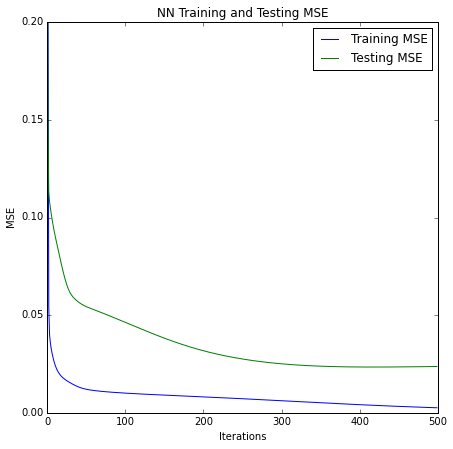

In [7]:
train_mse = clf.retrieve_training_mse()
test_mse = clf.retrieve_testing_mse()

fig = plt.figure(figsize = (7,7))
ax = plt.subplot(111)
ax.plot(train_mse, label = 'Training MSE')
ax.plot(test_mse, label = 'Testing MSE')
ax.set_title("NN Training and Testing MSE")
ax.set_ylabel("MSE")
ax.set_xlabel("Iterations")
ax.legend(loc='best')
ax.set_ylim(0.0, 0.2)

print clf.retrieve_final_n()

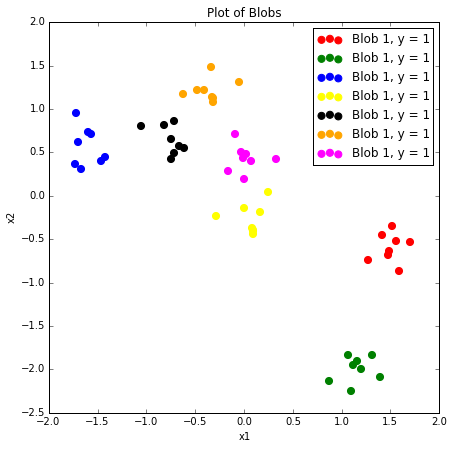

In [8]:
#number of training examples
m = 56

#number of features
N = 2

#number of distinct clusters or groupings or 'blobs'
num_blobs = 7

#using sklearn's 'make_blobs' functionality to make some clusters of data
#blobs also returns an array, y, which contains the identity of the blob each pair of points belongs to
X, y = make_blobs(n_samples = m, n_features = N, centers=num_blobs, cluster_std=0.75, random_state=6)

scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True).fit(X)
X_scaled = scaler.transform(X)

color_list = ['red', 'green', 'blue', 'yellow', 'black', 'orange', 'magenta', 'cyan']

#Plot the blobs and color them for each blob
fig = plt.figure(figsize = (7,7))
ax = plt.subplot(111)
for i in xrange(num_blobs):
    ax.scatter(X_scaled[y == i,0], X_scaled[y == i,1], color=color_list[i], s=50, label='Blob 1, y = 1')

ax.set_title("Plot of Blobs")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend(loc='best')

In [12]:
clfB = my_NeuralNet(hidden = 7, eta = 0.1, iterations = 100, epsilon = 5.0, lam = 0.001)
clfB.fit(X_scaled, y)

In [13]:
y_hat = clfB.predict(X_scaled)

In [14]:
cm = pd.crosstab(y, y_hat,rownames=["Actual"], colnames=["Predicted"])
cm

Predicted,0.0,1.0,2.0,3.0,4.0,5.0,6.0
Actual,,,,,,,
0,8,0,0,0,0,0,0
1,0,8,0,0,0,0,0
2,0,0,8,0,0,0,0
3,0,0,0,8,0,0,0
4,0,0,0,0,8,0,0
5,0,0,0,0,0,8,0
6,0,0,0,0,0,0,8


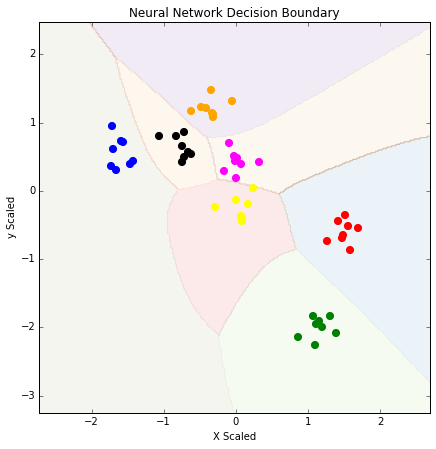

In [15]:
fig = plt.figure(figsize = (7, 7))
ax = plt.subplot(111)

#find the limits required for the plot
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1

#step size for the mesh
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#predict over the mesh
Z = clfB.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.1)

color_list = ['red', 'green', 'blue', 'yellow', 'black', 'orange', 'magenta', 'cyan']

#re-plot the points
for i in xrange(num_blobs):
    ax.scatter(X_scaled[y == i,0], X_scaled[y == i,1], color=color_list[i], s=50, label='Blob 1, y = 1')


ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_title("Neural Network Decision Boundary")
ax.set_xlabel("X Scaled")
ax.set_ylabel("y Scaled")